In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tqdm import tqdm
import os
import json
from IPython import display
import time
import pylab as pl
%matplotlib inline
import matplotlib.pyplot as plt
from seaborn import heatmap
%matplotlib inline

from datetime import date
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

from tqdm import tqdm
import os
import json
from datetime import date

import matplotlib.pyplot as plt
from seaborn import heatmap
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%bash
cp /content/drive/MyDrive/data_kr2/significant_SNPs_afr.csv .
cp /content/drive/MyDrive/data_kr2/significant_SNPs_eur.csv .
cp /content/drive/MyDrive/data_kr2/significant_SNPs_asn.csv .

cp /content/drive/MyDrive/data_kr2/target_for_vcf_afr.txt .
cp /content/drive/MyDrive/data_kr2/target_for_vcf_eur.txt .
cp /content/drive/MyDrive/data_kr2/target_for_vcf_asn.txt .

cp /content/drive/MyDrive/data_kr2/afr_data.csv.gz .
cp /content/drive/MyDrive/data_kr2/eur_data.csv.gz .
cp /content/drive/MyDrive/data_kr2/asn_data.csv.gz .

In [ ]:
! gunzip afr_data.csv.gz
! gunzip eur_data.csv.gz
! gunzip asn_data.csv.gz

In [ ]:
afr_pop = pd.read_csv('afr_data.csv')
eur_pop = pd.read_csv('eur_data.csv')
asn_pop = pd.read_csv('asn_data.csv')

In [ ]:
afr_pop = afr_pop.drop(columns=['Unnamed: 0'])
asn_pop = asn_pop.drop(columns=['Unnamed: 0'])
eur_pop = eur_pop.drop(columns=['Unnamed: 0'])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [ ]:
significant_snps_afr = pd.read_csv('significant_SNPs_afr.csv')
significant_snps_eur = pd.read_csv('significant_SNPs_eur.csv')
significant_snps_asn = pd.read_csv('significant_SNPs_asn.csv')

In [ ]:
significant_snps_afr = significant_snps_afr['SNP']
significant_snps_eur = significant_snps_eur['SNP']
significant_snps_asn = significant_snps_asn['SNP']

In [ ]:
target_eur = pd.read_csv('target_for_vcf_eur.txt', delimiter='\t')
target_afr = pd.read_csv('target_for_vcf_afr.txt', delimiter='\t')
target_asn = pd.read_csv('target_for_vcf_asn.txt', delimiter='\t')

In [ ]:
target_eur['pheno'] = target_eur['pheno'].replace(1,'0')
target_eur['pheno'] = target_eur['pheno'].replace(2,'1')

target_afr['pheno'] = target_afr['pheno'].replace(1,'0')
target_afr['pheno'] = target_afr['pheno'].replace(2,'1')

target_asn['pheno'] = target_asn['pheno'].replace(1,'0')
target_asn['pheno'] = target_asn['pheno'].replace(2,'1')

## Preprocessing

Train - EUR

Test - EUR

In [ ]:
X = afr_pop[significant_snps_afr]

In [ ]:
X.to_csv('data.csv',   index=False, header=False)

In [ ]:
y = target_afr['pheno']

In [ ]:
y.to_csv('target.csv', index=False, header=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.to_csv('Xtrain.csv',  index=False, header=False)
X_test.to_csv('Xtest.csv',  index=False, header=False)
y_train.to_csv('Ytrain.csv',  index=False, header=False)
y_test.to_csv('Ytest.csv',  index=False, header=False)

In [ ]:
# results saved to json
json_output = r'./GridSearch_results.json'
flat_json_output = True

In [ ]:
def write_json(current_results, file_name=json_output):
    with open(file_name, 'a') as file:
        if flat_json_output:
            file.write(json.dumps(current_results))
        else:
            file.write(json.dumps(current_results, indent=1))
        file.write('\n')

### Deep Learning MODELS

MLP

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
y = target_eur['pheno']

In [ ]:
from sklearn.model_selection import train_test_split



train, test = train_test_split(y, test_size=0.2, random_state=5)
train, val = train_test_split(
    train, test_size=0.25, stratify=train, random_state=5)  # 0.25 x 0.8 = 0.2

case_indexes = np.where(train == 1)[0]
control_indexes = np.where(train == 0)[0]

train_index = train.index

val_index = val.index
test_index = test.index

In [ ]:
class PRS_Dataset(Dataset):

    """
    Loads features and tatget. take = n -> take *first* n entries for dataset (if train = True);
    take *last* n entries for dataset (if train = False)
    """

    def __init__(self, x_path, y_path, mode, imbalance=None):

        print(f"### Mode: {mode} ###")
        y = np.loadtxt(y_path, delimiter=',', dtype=np.float32)
        print(f"Overall target shape: {y.shape}")
        x = np.loadtxt(x_path, delimiter=',', dtype=np.float32)

        if mode == 'train':
            x = x[train_index]
            y = y[train_index]

        elif mode == 'test':
            x = x[test_index]
            y = y[test_index]

        elif mode == 'val':
            x = x[val_index]
            y = y[val_index]

        else:
            raise ValueError('Incorrect mode')

        self.x_data = torch.from_numpy(x).to(torch.float32)
        self.y_data = torch.from_numpy(y).to(torch.float32)
        self.y_data = self.y_data.unsqueeze(1)
        print(f"x_data {self.x_data.shape}")
        print(f"y_data {self.y_data.shape}")

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.y_data)

In [ ]:
# paths
features_path = "data.csv" #"./data/features_imbalanced.csv"   # "./data/feature_matrix_2k.csv"
target_path =  "target.csv"

In [ ]:
batch_size=512

In [ ]:
train_dataset = PRS_Dataset(features_path, target_path,
                                mode='train')

val_dataset = PRS_Dataset(features_path, target_path,
                          mode='val')
test_dataset = PRS_Dataset(features_path, target_path,
                           mode='test')


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)


### Mode: train ###
Overall target shape: (5000,)
x_data torch.Size([3000, 1483])
y_data torch.Size([3000, 1])
### Mode: val ###
Overall target shape: (5000,)
x_data torch.Size([1000, 1483])
y_data torch.Size([1000, 1])
### Mode: test ###
Overall target shape: (5000,)
x_data torch.Size([1000, 1483])
y_data torch.Size([1000, 1])


In [ ]:
display_stats = True
display_every_n_epochs = 20

if display_stats:
    from IPython import display
    import pylab as pl

today = date.today()

In [ ]:
# data info
input_size = 1483  # сколько SNP включено в модель

# model info
params = {
    'epochs': [60],
    'lr': [0.001],
    'bn_momentum': [0.8, 0.9],  # batch norm momentum
    'first_dropout': [0.7, 0.9],
    'other_dropouts': [0.7, 0.9],
    'lin1_output': [800, 1200],  # edit to change shapes of the linear layers
    'lin2_output': [250, 300],
    'lin3_output': [20, 50]
}

batch_size = 4096

In [ ]:
class P1(nn.Module):
    def __init__(self, input_size, bn_momentum=0.9, first_dropout=0.9, other_dropouts=0.9,
                 lin1_output=1000, lin2_output=250, lin3_output=50):
        super(P1, self).__init__()
        self.lin1 = nn.Linear(input_size, lin1_output)
        self.bn1 = nn.BatchNorm1d(lin1_output, momentum=bn_momentum)
        self.lin2 = nn.Linear(lin1_output, lin2_output)
        self.bn2 = nn.BatchNorm1d(lin2_output, momentum=bn_momentum)

        self.lin3 = nn.Linear(lin2_output, lin3_output)
        self.bn3 = nn.BatchNorm1d(lin3_output, momentum=bn_momentum)

        self.lin4 = nn.Linear(lin3_output, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=first_dropout)
        self.dropout_other = nn.Dropout(p=other_dropouts)

    def forward(self, X):
        X = self.lin1(X)
        X = self.relu(X)
        X = self.bn1(X)
        X = self.dropout_first(X)

        X = self.lin2(X)
        X = self.relu(X)
        X = self.bn2(X)
        X = self.dropout_other(X)

        X = self.lin3(X)
        X = self.relu(X)
        X = self.bn3(X)

        X = self.dropout_other(X)

        X = self.lin4(X)
        X = self.sigmoid(X)

        return X

In [ ]:
def collect_metrics(y_true, y_pred_prob, y_pred_class, current_params = None):

    roc_auc = roc_auc_score(y_true, y_pred_prob)
    pr_auc = average_precision_score(y_true, y_pred_prob)
    recall = recall_score(y_true, y_pred_class)
    precision = precision_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    accuracy = accuracy_score(y_true, y_pred_class)

    if current_params:
        current_params['test_ROC_AUC'] = roc_auc
        current_params['test_PR_AUC'] = pr_auc
        current_params['test_recall'] = recall
        current_params['test_precision'] = precision
        current_params['test_f1'] = f1
        current_params['test_accuracy'] = accuracy
    else:
        return {'ROC_AUC': roc_auc,'PR AUC': pr_auc, 'recall': recall, 'precision': precision,
               'f1':f1, 'accuracy':accuracy}

In [ ]:
def plot_stats(loss_history, auc_history, current_params, save_stats=False):
    """Plot loss and ROC AUC in jupyter notebook"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # loss (ax1)
    training_loss = loss_history['train']
    val_loss = loss_history['val']

    epoch_count = range(1, len(training_loss) + 1)

    ax1.plot(epoch_count, training_loss, '-r')
    ax1.plot(epoch_count, val_loss, '-b')
    ax1.legend(['Training loss', 'Validation loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # auc (ax2)
    training_auc = auc_history['train']
    val_auc = auc_history['val']

    ax2.plot(epoch_count, training_auc, '-r')
    ax2.plot(epoch_count, val_auc, '-b')
    ax2.legend(['Training ROC AUC', 'Validation ROC AUC'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('ROC AUC')

    # print current model parameters (ax3)
    text = f"Run number: {current_params['run']} \
    \nTraining with the following parameters: \
    \nepochs: {current_params['settings']['overall_epochs']} \
    \nlearning rate: {current_params['settings']['lr']},\
    \nbatch_norm momentum: {current_params['settings']['bn_momentum']},\
    \nfirst layer dropout: {current_params['settings']['first_dropout']},\
    \nother layer dropouts: {current_params['settings']['other_dropouts']},\
    \n1st layer output size: {current_params['settings']['lin1_output']},\
    \n2nd layer output size: {current_params['settings']['lin2_output']},\
    \n3rd layer output size: {current_params['settings']['lin3_output']}"
    ax3.text(0, 0.5, text, ha='left')
    ax3.axis('off')

    fig.tight_layout()

    if display_stats:
        display.clear_output(wait=True)
        display.display(pl.gcf())
    if save_stats:
        # save loss and roc auc history
        dir_path = f"./figures_{today}"
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        fig.savefig(f"{dir_path}/run{current_params['run']}_training.png", dpi=fig.dpi)

In [ ]:
def plot_curves(curves, current_params):
    fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2, figsize=(10, 10))

    # PR curve
    ax1.plot(curves['PR']['recall'], curves['PR']['precision'])
    ax1.title.set_text('Precision-Recall Curve')
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Recall')

    # ROC curve
    ax2.plot(curves['ROC']['false_positive_rate'], curves['ROC']
             ['true_positive_rate'], label='AUC = %0.2f' % current_params['test_ROC_AUC'])
    ax2.title.set_text('ROC Curve')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')
    ax2.legend(loc = 'lower right')

    # confusion matrix
    conf_matrix = np.array(([current_params['confusion_matrix']['TP'],
                                     current_params['confusion_matrix']['FP']],
                                   [current_params['confusion_matrix']['FN'],
                                   current_params['confusion_matrix']['TN']]))



    ax4 = heatmap(conf_matrix, annot=True, fmt=".1f")
    ax4.set(xlabel="Predicted Label", ylabel="True Label")
    ax4.title.set_text('Confusion matrix')


    # model info
    text = f"Run number: {current_params['run']} \
    \nTraining with the following parameters: \
    \nepochs: {current_params['settings']['overall_epochs']} \
    \nlearning rate: {current_params['settings']['lr']},\
    \nbatch_norm momentum: {current_params['settings']['bn_momentum']},\
    \nfirst layer dropout: {current_params['settings']['first_dropout']},\
    \nother layer dropouts: {current_params['settings']['other_dropouts']},\
    \n1st layer output size: {current_params['settings']['lin1_output']},\
    \n2nd layer output size: {current_params['settings']['lin2_output']},\
    \n3rd layer output size: {current_params['settings']['lin3_output']}"
    ax3.text(0, 0.5, text, ha='left')
    ax3.axis('off')

    fig.tight_layout()

    # save
    dir_path = f"./figures_{today}"
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    fig.savefig(f"{dir_path}/run{current_params['run']}_summary.png", dpi=fig.dpi)

In [ ]:
def training_loop(n, epochs, learning_rate, bn_momentum, first_dropout,
                  other_dropouts, lin1_output, lin2_output, lin3_output):
    """
    Trains a single net on the supplied params.
    Returns average ROC AUC on the whole test dataset after learning is complete.
    """
    early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

    model = P1(input_size, bn_momentum=bn_momentum,
               first_dropout=first_dropout, other_dropouts=other_dropouts,
               lin1_output=lin1_output, lin2_output=lin2_output,
               lin3_output=lin3_output).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    scheduler = CosineAnnealingWarmRestarts(optimizer,
                                            T_0=10,  # Number of iterations for the first restart
                                            T_mult=1,  # A factor increases TiTi after a restart
                                            eta_min=1e-4)  # Minimum learning rate

    # summary of the current model
    current_params = {
        'date':str(today),
        'run': n,
        'settings': {
            'overall_epochs': epochs,
            'lr': learning_rate,
            'bn_momentum': bn_momentum,
            'first_dropout': first_dropout,
            'other_dropouts': other_dropouts,
            'lin1_output': lin1_output,
            'lin2_output': lin2_output,
            'lin3_output': lin3_output
        }
    }

    auc_history = {'train': [], 'val': []}
    aucs = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    best_val_auc = 0  # ищем лучший auc по эпохам
    best_epoch = None  # ищем лучшую эпоху
    best_model = None

    for epoch in tqdm(range(epochs)):
        for x_batch, y_batch in train_loader:
            model.train()
            # forward pass
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            losses['train'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['train'].append(np.mean(roc_auc_score(
                y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # check current performance on val
        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                pred_val = model(x_val)
                loss = criterion(pred_val, y_val)

                losses['val'].append(np.mean(loss.detach().cpu().numpy()))
                aucs['val'].append(np.mean(roc_auc_score(
                    y_val.detach().cpu().numpy(), pred_val.detach().cpu().numpy())))

        # scheduler step
        scheduler.step()

        # plot statistics
        loss_history['train'].append(sum(losses['train'])/len(losses['train']))
        loss_history['val'].append(sum(losses['val'])/len(losses['val']))
        validation_loss = sum(losses['val'])/len(losses['val'])
        losses = {'train': [], 'val': []}

        curr_val_auc = sum(aucs['val'])/len(aucs['val'])  # current val auc
        auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
        auc_history['val'].append(curr_val_auc)
        aucs = {'train': [], 'val': []}

        if curr_val_auc > best_val_auc:  # current best model
            best_epoch = epoch
            best_model = model.state_dict()

        if display_stats and (epoch % display_every_n_epochs == 0):
            plot_stats(loss_history, auc_history, current_params)

        # early stopper
        if early_stopper.early_stop(validation_loss):
            break

    # performance on the test dataset
    # load best model params
    model.load_state_dict(best_model)
    model.eval()

    overall_pred_test = []
    overall_pred_test_class = []
    overall_y_test = []
    ovarall_confmatrix = np.zeros((2, 2))

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.cpu().numpy()
            pred_test = model(x_test).detach().cpu().numpy()
            pred_test_class = np.rint(pred_test)
            # append predicts
            #print(type(y_test))#.shape)
            overall_y_test += list(y_test.flatten())
            overall_pred_test += list(pred_test.flatten())
            overall_pred_test_class += list(pred_test_class.flatten())
            ovarall_confmatrix += confusion_matrix(y_test, pred_test_class)

    # collect metrics
    #print(overall_y_test)
    overall_y_test = np.array(overall_y_test).reshape(-1, 1)
    overall_pred_test = np.array(overall_pred_test).reshape(-1, 1)
    overall_pred_test_class = (
        np.array(overall_pred_test_class).reshape(-1, 1))


    collect_metrics(overall_y_test, overall_pred_test, overall_pred_test_class, current_params)
    current_params['confusion_matrix'] = {'TP': ovarall_confmatrix[0][0],
                                          'TN': ovarall_confmatrix[1][1],
                                          'FP': ovarall_confmatrix[0][1],
                                          'FN': ovarall_confmatrix[1][0]}
    current_params['best_epochs'] = best_epoch

    plot_stats(loss_history, auc_history, current_params, save_stats=True)

    # calculate curves
    curves = {'ROC':{}, 'PR':{}}
    curves['ROC']['false_positive_rate'], curves['ROC']['true_positive_rate'], _ = roc_curve(
        overall_y_test, overall_pred_test)
    curves['PR']['precision'], curves['PR']['recall'], _ = precision_recall_curve(
        overall_y_test, overall_pred_test_class)
    # plot curves
    plot_curves(curves, current_params)


    return current_params


In [ ]:
print(f"Overall training cycles: {np.prod(np.array([len(v) for v in params.values()]))}")


Overall training cycles: 64


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# early stopper
# стоппер сработает, если val loss будет больше, чем min val loss на min_delta
min_delta = 0.08
patience = 5

In [1]:
# hyperparam grid search
grid_search = []
total_searches = np.prod(np.array([len(v) for v in params.values()]))
i = 1

for epoch in params['epochs']:
    for lr in params['lr']:
        for first in params['lin1_output']:
            for second in params['lin2_output']:
                for third in params['lin3_output']:
                    for bnm in params['bn_momentum']:
                        for fdrop in params['first_dropout']:
                            for odrop in params['other_dropouts']:
                                print(f"Grid Search step {i} of total {total_searches}")
                                current_results = training_loop(i, epoch, lr, bnm, fdrop,
                                                                 odrop, first, second, third)
                                grid_search.append(current_results)
                                write_json(current_results)
                                i += 1

# results = sorted(grid_search, key=lambda d: d['test_ROC_AUC'], reverse=True)

In [ ]:
! cp -r figures_2023-10-09 afr

In [ ]:
! cp -r afr /content/drive/MyDrive/

In [ ]:
def plot_stats(loss_history, auc_history):
    """Plot loss and ROC AUC in jupyter notebook"""

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 5))

    # loss
    training_loss = loss_history['train']
    test_loss = loss_history['test']

    epoch_count = range(1, len(training_loss) + 1)

    ax1.plot(epoch_count, training_loss, '-r')
    ax1.plot(epoch_count, test_loss, '-b')
    ax1.legend(['Training loss', 'Test loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # auc
    training_auc = auc_history['train']
    test_auc = auc_history['test']

    ax2.plot(epoch_count, training_auc, '-r')
    ax2.plot(epoch_count, test_auc, '-b')
    ax2.legend(['Training ROC AUC', 'Test ROC AUC'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('ROC AUC')

    fig.tight_layout()

    display.clear_output(wait=True)
    display.display(pl.gcf())
    #time.sleep(1.0)

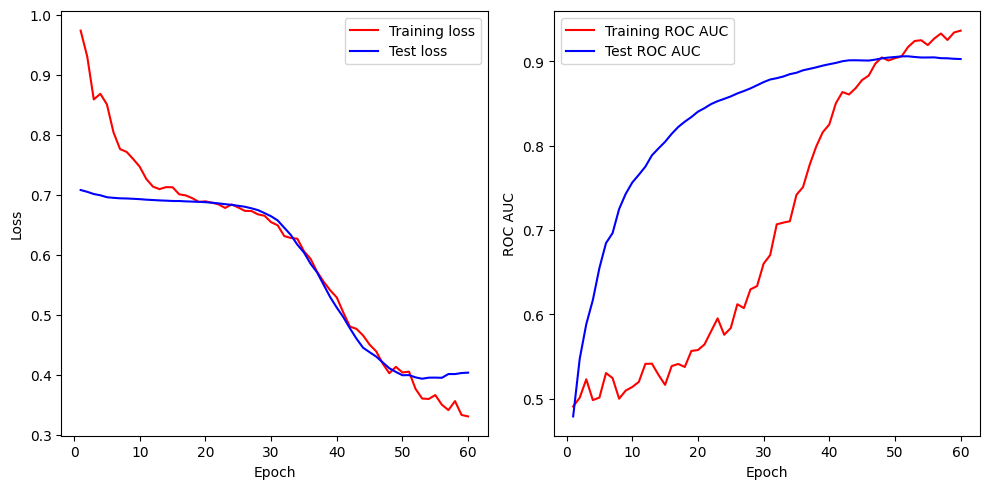

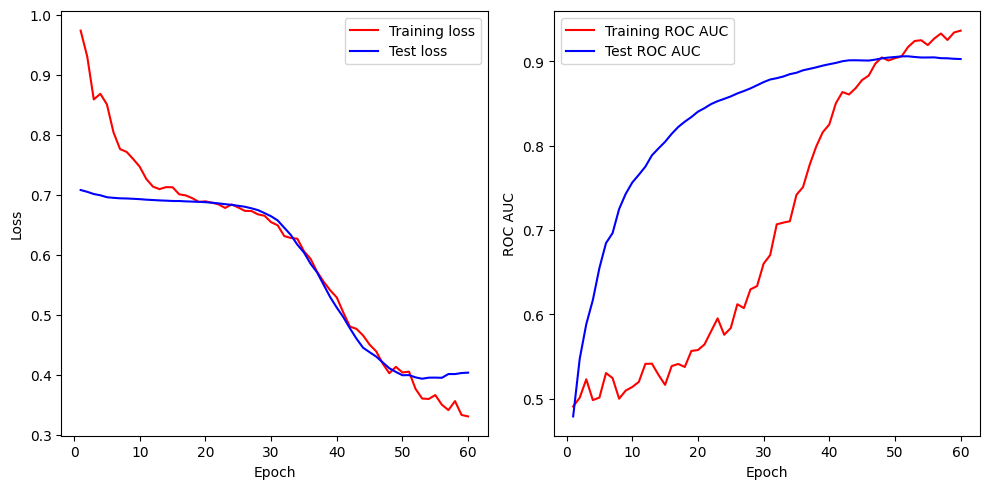

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(60)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
dict_metrics_eur_eur = {}

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)
print('ROC-AUC = ', Model_ROC_AUC)

ROC-AUC =  0.8937903522864491


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       657
           1       0.78      0.84      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
dict_metrics_eur_eur['roc_mlp'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_mlp'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_mlp'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_mlp'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_mlp'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, batch_size=512, bn_momentum=0.9, drop=(0.9, 0.9)):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=1000, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=1000, out_channels=500, kernel_size=1, stride=1)
        #self.conv3 = nn.Conv1d(in_channels=500, out_channels=500, kernel_size=1, stride=1)
        self.lin1 = nn.Linear(500, 250)
        self.lin2 = nn.Linear(250, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=drop[0])
        self.dropout_other = nn.Dropout(p=drop[1])

    def forward(self, X):
        X = torch.unsqueeze(X, 1)
        X = X.transpose(1, 2)
        x_cnn1 = self.conv1(X)
        x_cnn2 = self.conv2(x_cnn1)
        #x_cnn3 = self.conv3(x_cnn2)
        X = torch.squeeze(x_cnn2)

        X = self.dropout_first(X)
        X = self.lin1(X)

        X = self.relu(X)
        X = self.lin2(X)
        X = self.sigmoid(X)

        return X

In [ ]:
model = CNN(1555, batch_size=batch_size, bn_momentum=0.9,
           drop=(0.9, 0.9)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

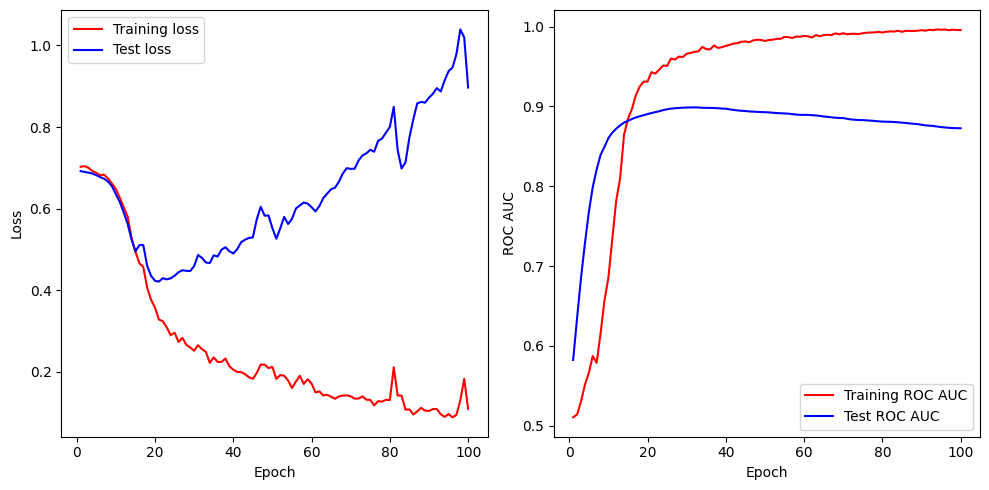

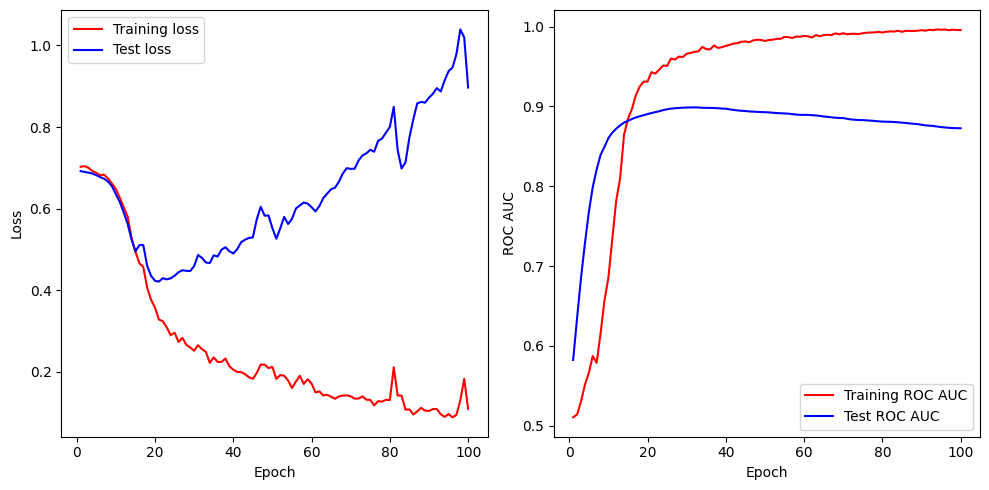

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(60)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
print(f"Model ROC AUC: {Model_ROC_AUC:.3}")

Model ROC AUC: 0.865


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       657
           1       0.75      0.81      0.78       592

    accuracy                           0.78      1249
   macro avg       0.78      0.78      0.78      1249
weighted avg       0.78      0.78      0.78      1249



In [ ]:
dict_metrics_eur_eur['roc_cnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_cnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_cnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_cnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_cnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

RNN

In [ ]:
class LSTMClassification(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size):
        super(LSTMClassification, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, target_size)
        self.hidden_dim = hidden_dim
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_):
        input_ = input_.unsqueeze(dim=1)
        lstm_out, (h, c) = self.lstm(input_)
        lstm_out = lstm_out.view(-1, self.hidden_dim)
        logits = self.fc(lstm_out)
        scores = self.sigmoid(logits)
        return scores


In [ ]:
input_dim = 1555 # здесь ввести input_dim в зависимости от x_data
hidden_dim = round(input_dim/2)

In [ ]:
model = LSTMClassification(input_dim=input_dim, hidden_dim=hidden_dim, target_size=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

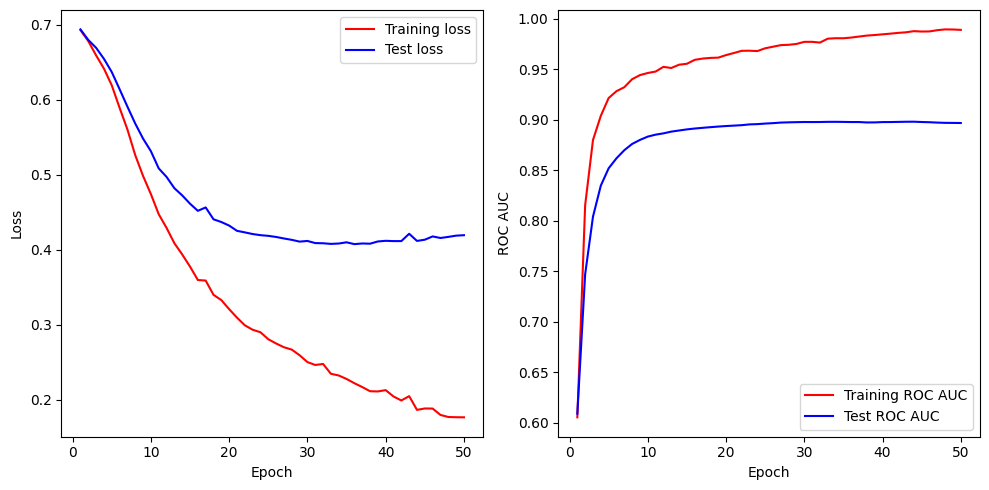

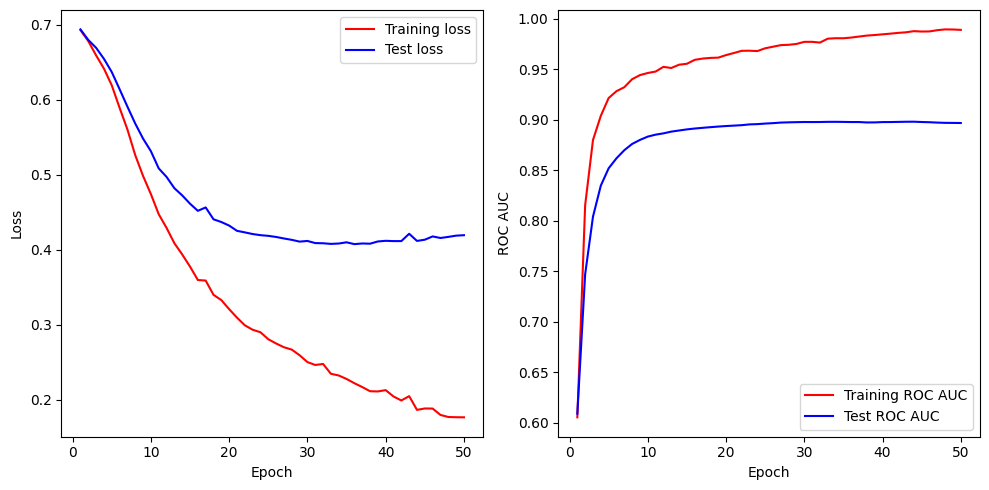

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(50)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}

plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
print(f"Model ROC AUC: {Model_ROC_AUC:.3}")

Model ROC AUC: 0.889


In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       657
           1       0.77      0.85      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
dict_metrics_eur_eur['roc_rnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_rnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_rnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_rnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_rnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

CNN + RNN

In [ ]:
class RNN_CNN(nn.Module):
    def __init__(self, input_size, batch_size=512, bn_momentum=0.9, drop=0.9):
        super(RNN_CNN, self).__init__()

        self.lstm = nn.LSTM(input_size, 500, batch_first=True, bidirectional=True)

        self.conv1 = nn.Conv1d(in_channels=1000, out_channels=2000, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=2000, out_channels=500, kernel_size=1, stride=1)

        self.lin2 = nn.Linear(500, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.dropout_first = nn.Dropout(p=drop)
        self.dropout_other = nn.Dropout(p=drop)

    def forward(self, X):
        X = torch.unsqueeze(X, 1)
        lstm_out, (h, c) = self.lstm(X)
        X = self.dropout_first(lstm_out)
        X = X.transpose(1, 2)

        x_cnn1 = self.conv1(X)
        x_cnn2 = self.conv2(x_cnn1)
        X = torch.squeeze(x_cnn2)

        X = self.relu(X)
        X = self.lin2(X)
        X = self.sigmoid(X)

        return X

In [ ]:
input_size = 1555

In [ ]:
model = RNN_CNN(input_size, batch_size=batch_size, bn_momentum=0.9,
           drop=0.9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

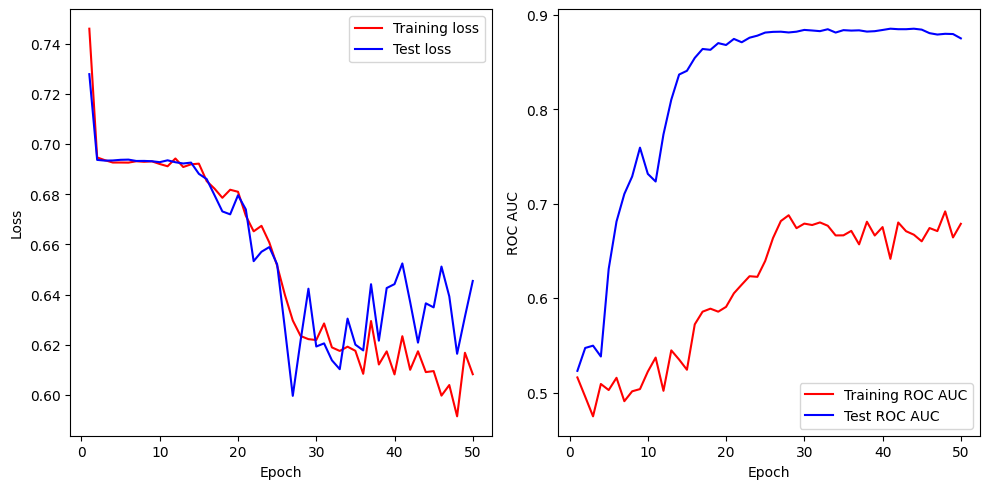

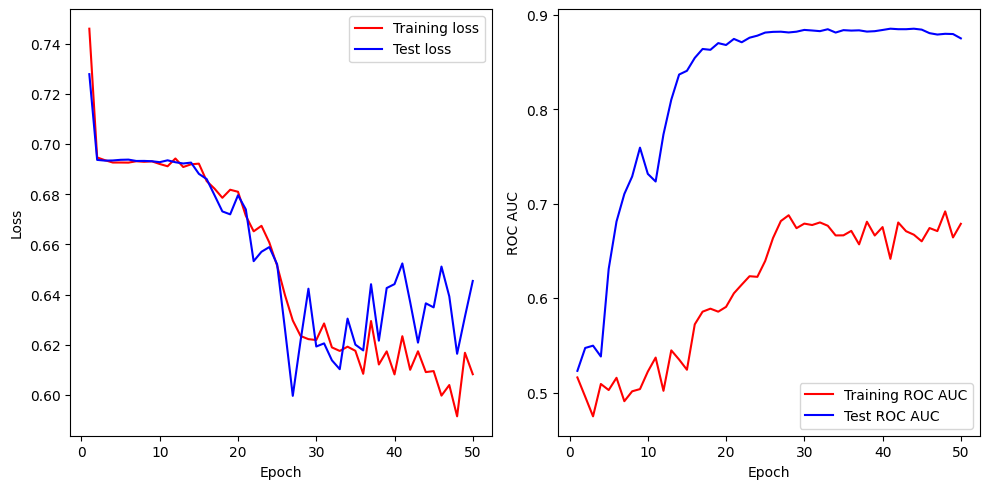

In [ ]:
auc_history = {'train': [], 'test': []}
aucs = {'train': [], 'test': []}
loss_history = {'train': [], 'test': []}
losses = {'train': [], 'test': []}

for epoch in tqdm(range(50)):
    for i, (x_batch, y_batch) in enumerate(train_loader):
        model.train()
        # forward pass
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        losses['train'].append(np.mean(loss.detach().cpu().numpy()))
        aucs['train'].append(np.mean(roc_auc_score(
            y_batch.detach().cpu().numpy(), pred.detach().cpu().numpy())))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check performance on test
        model.eval()
        with torch.no_grad():
            test_example = iter(test_loader)
            x_test, y_test = next(test_example)
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            pred_test = model(x_test)
            loss = criterion(pred_test, y_test)
            losses['test'].append(np.mean(loss.detach().cpu().numpy()))
            aucs['test'].append(np.mean(roc_auc_score(
                y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

    # plot statistics
    loss_history['train'].append(sum(losses['train'])/len(losses['train']))
    loss_history['test'].append(sum(losses['test'])/len(losses['test']))
    losses = {'train': [], 'test': []}
    auc_history['train'].append(sum(aucs['train'])/len(aucs['train']))
    auc_history['test'].append(sum(aucs['test'])/len(aucs['test']))
    aucs = {'train': [], 'test': []}
plot_stats(loss_history, auc_history)

In [ ]:
# performance on the test dataset
overall_test_aucs = []
overall_pred_values = []
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        pred_test = model(x_test)
        overall_pred_values.append(pred_test)
        overall_test_aucs.append(np.mean(roc_auc_score(
            y_test.detach().cpu().numpy(), pred_test.detach().cpu().numpy())))

Model_ROC_AUC = sum(overall_test_aucs)/len(overall_test_aucs)

In [ ]:
all_preds = []
for el in overall_pred_values:
  el = el.to('cpu')
  el = el.detach().numpy()
  for k in el:
    all_preds.append(round(k[0]))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.y_data.numpy().ravel(), all_preds, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      0.64      0.75       657
           1       0.70      0.91      0.79       592

    accuracy                           0.77      1249
   macro avg       0.79      0.78      0.77      1249
weighted avg       0.80      0.77      0.77      1249



In [ ]:
dict_metrics_eur_eur['roc_cnn_rnn'] = Model_ROC_AUC
dict_metrics_eur_eur['accuracy_cnn_rnn'] = accuracy_score(test_dataset.y_data.numpy().ravel(), all_preds)
dict_metrics_eur_eur['recall_cnn_rnn'] = recall_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['precision_cnn_rnn'] = precision_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')
dict_metrics_eur_eur['f1_cnn_rnn'] = f1_score(test_dataset.y_data.numpy().ravel(), all_preds, average='weighted')

### Machine Learning MODELS

Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter = 1000, penalty = 'l2', solver='saga')
logreg.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())
LogReg_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    logreg.predict_proba(test_dataset.x_data.numpy())[:, 1])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       657
         1.0       0.73      0.78      0.75       592

    accuracy                           0.76      1249
   macro avg       0.76      0.76      0.76      1249
weighted avg       0.76      0.76      0.76      1249



In [ ]:
LogReg_ROC_AUC

0.8510556789666379

In [ ]:
dict_metrics_eur_eur['roc_logreg'] = LogReg_ROC_AUC
dict_metrics_eur_eur['accuracy_logreg'] = accuracy_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_logreg'] = recall_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_logreg'] = precision_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_logreg'] = f1_score(test_dataset.y_data.numpy().ravel(), logreg.predict(test_dataset.x_data.numpy()), average='weighted')

Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=2, random_state=0).fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       657
         1.0       0.71      0.74      0.72       592

    accuracy                           0.73      1249
   macro avg       0.73      0.73      0.73      1249
weighted avg       0.73      0.73      0.73      1249



In [ ]:
GB_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    gbc.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
GB_ROC_AUC

0.798076329754412

In [ ]:
dict_metrics_eur_eur['roc_gb'] = GB_ROC_AUC
dict_metrics_eur_eur['accuracy_gb'] = accuracy_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_gb'] = recall_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_gb'] = precision_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_gb'] = f1_score(test_dataset.y_data.numpy().ravel(), gbc.predict(test_dataset.x_data.numpy()), average='weighted')

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=100, random_state=0)
rf_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

RandomForestClassifier(max_depth=100, random_state=0)

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.61      0.52      0.56       657
         1.0       0.54      0.63      0.58       592

    accuracy                           0.57      1249
   macro avg       0.58      0.58      0.57      1249
weighted avg       0.58      0.57      0.57      1249



In [ ]:
RF_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    rf_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
RF_ROC_AUC

0.6052735098111811

In [ ]:
dict_metrics_eur_eur['roc_rf'] = RF_ROC_AUC
dict_metrics_eur_eur['accuracy_rf'] = accuracy_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_rf'] = recall_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_rf'] = precision_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_rf'] = f1_score(test_dataset.y_data.numpy().ravel(), rf_clf.predict(test_dataset.x_data.numpy()), average='weighted')

SVM

In [ ]:
from sklearn import svm

In [ ]:
svm_clf = svm.SVC(probability=True)
svm_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

SVC(probability=True)

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82       657
         1.0       0.78      0.83      0.81       592

    accuracy                           0.81      1249
   macro avg       0.81      0.81      0.81      1249
weighted avg       0.81      0.81      0.81      1249



In [ ]:
SVM_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    svm_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
SVM_ROC_AUC

0.8898684643547656

In [ ]:
dict_metrics_eur_eur['roc_svm'] = SVM_ROC_AUC
dict_metrics_eur_eur['accuracy_svm'] = accuracy_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_svm'] = recall_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_svm'] = precision_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_svm'] = f1_score(test_dataset.y_data.numpy().ravel(), svm_clf.predict(test_dataset.x_data.numpy()), average='weighted')

Desicion Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=100)
dt_clf.fit(train_dataset.x_data.numpy(), train_dataset.y_data.numpy().ravel())

DecisionTreeClassifier(max_depth=100)

In [ ]:
print(classification_report(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy())))

              precision    recall  f1-score   support

         0.0       0.57      0.52      0.55       657
         1.0       0.52      0.56      0.54       592

    accuracy                           0.54      1249
   macro avg       0.54      0.54      0.54      1249
weighted avg       0.54      0.54      0.54      1249



In [ ]:
DT_ROC_AUC = roc_auc_score(test_dataset.y_data.numpy().ravel(),
                    dt_clf.predict_proba(test_dataset.x_data.numpy())[:, 1])

In [ ]:
DT_ROC_AUC

0.5430460426179604

In [ ]:
dict_metrics_eur_eur['roc_dt'] = DT_ROC_AUC
dict_metrics_eur_eur['accuracy_dt'] = accuracy_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()))
dict_metrics_eur_eur['recall_dt'] = recall_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['precision_dt'] = precision_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')
dict_metrics_eur_eur['f1_dt'] = f1_score(test_dataset.y_data.numpy().ravel(), dt_clf.predict(test_dataset.x_data.numpy()), average='weighted')

In [ ]:
dict_metrics_eur_eur

{'roc_mlp': 0.8937903522864491,
 'accuracy_mlp': 0.8102481985588471,
 'recall_mlp': 0.8102481985588471,
 'precision_mlp': 0.8129349074135737,
 'f1_mlp': 0.8103435765932885,
 'roc_cnn': 0.8648233875959254,
 'accuracy_cnn': 0.7798238590872698,
 'recall_cnn': 0.7798238590872698,
 'precision_cnn': 0.7828149741930204,
 'f1_cnn': 0.779913631435389,
 'roc_rnn': 0.8887729618677511,
 'accuracy_rnn': 0.8054443554843875,
 'recall_rnn': 0.8054443554843875,
 'precision_rnn': 0.8095841280935921,
 'f1_rnn': 0.8054600696243563,
 'roc_cnn_rnn': 0.8718782046481838,
 'accuracy_cnn_rnn': 0.7686148919135308,
 'recall_cnn_rnn': 0.7686148919135308,
 'precision_cnn_rnn': 0.7956209879418765,
 'f1_cnn_rnn': 0.7655627721623908,
 'roc_logreg': 0.8510556789666379,
 'accuracy_logreg': 0.7590072057646117,
 'recall_logreg': 0.7590072057646117,
 'precision_logreg': 0.7609473434597989,
 'f1_logreg': 0.7591592726543483,
 'roc_gb': 0.798076329754412,
 'accuracy_gb': 0.7317854283426741,
 'recall_gb': 0.7317854283426741,
 